
# Feature Engineering

This notebook summarizes the feature engineering steps of the pipeline. After all data is downloaded, harmonized and cut to the boundaries of the city, features are calculated per TAZ. The pipeline includes the following five featuress:

- [Distance to center](feature_engineering.ipynb#1-distance-to-center)
- [Distance to employment](feature_engineering.ipynb#2-distance-to-employment)
- [Population density](feature_engineering.ipynb#3-population-density)
- [Income](feature_engineering.ipynb#4-income)
- [Street connectivity](feature_engineering.ipynb#5-street-connectivity)

**Data availability:**  
The notebook uses the example of Boston in the US. The grid cells, population count and income can be retrieved from [US Census Data](https://www.census.gov/data.html), filtering for all block groups in Massachusetts. Streetnetwork data is download from Open Street Map via [osmnx](https://osmnx.readthedocs.io/en/stable/) - for further info also check out `xml4uf/downloading/download_streets.py`. The center of a city is defined via google maps (search for Boston and right click on Boston to get coordinates in epsg:4326).

**Questions or comments:**   
Feel free to open an issue in git or get in touch via wagner(at)mcc-berlin.de


## 0. Imports 

In [78]:
import sys, os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox

# import utils from xml4uf
PROJECT_SRC_PATH = os.getcwd().rsplit('/',1)[0]+'/xml4uf'
sys.path.append(PROJECT_SRC_PATH)
import utils.utils as utils

# define where your data is stored
path_root = utils.get_path_root()

In [63]:
# define city and respective crs 
city = 'bos' # Boston
crs_local = utils.get_crs_local(city)

# load grid of example city
grid = utils.read_raw_zip_geoms(path_root,city,crs_local)
grid.head(3) # each gridcell has a unqiue id in 'tractid'

,tractid,geometry
0,630400,"POLYGON ((2798795.938 5028715.690, 2798768.808..."
1,631100,"POLYGON ((2798768.808 5028674.470, 2798795.938..."
2,631300,"POLYGON ((2803471.617 5031988.430, 2803466.184..."


## 1 Distance to center
To calculate the feature distance to center we need osm streetnetwork data, the coordinate of the main center as well as the centroids of the TAZ polygons (also referred to as grid cells).

In [69]:
# get streetnetwork graph from osmnx
g = utils.read_graph(path_root, city, 'full') # full indicates that the graph is not filtered and contains all street types
# get coordinate of main center 
gdf_center = utils.read_cbd(path_root, city, crs_local)
gdf_center

,geometry
0,POINT (2806152.496 5084330.188)


In [65]:
# to calculate the distance to the center for each grid cell we need to import the shortest_distance_graph() function from ufo map (github.com/ai4up/ufo-map)
from ufo_map.Feature_engineering.city_level import shortest_distance_graph
ft_cbd = shortest_distance_graph(grid, # grid cells
                                gdf_center, # city center
                                g, # osmnx graph
                                'ft_cbd'# name of the new feature column
                                ) 

# for each TAZ grid cell we get a shortest path to the center (red star in the plot above)
ft_cbd.head(5)

,tractid,ft_cbd
0,630400,52542.488490
1,631100,57485.748622
2,631300,51536.048304
3,631200,55511.245651
4,631400,53550.099401


Text(0.5, 1.0, 'Feature distance to center [km]')

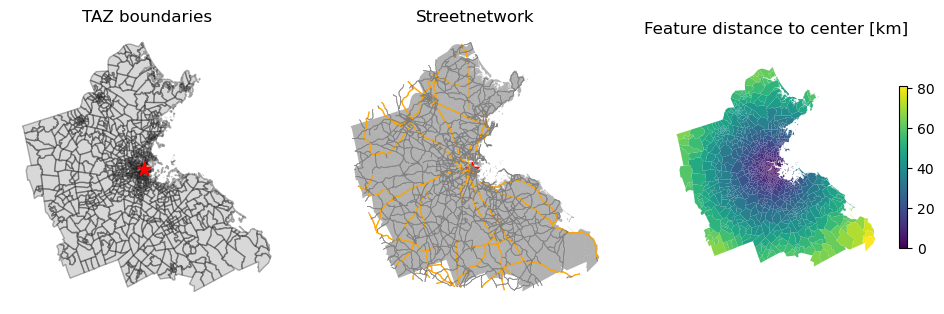

In [68]:
# to visualize the feature, we merge it with the grid polygons
gdf_ft_cbd = pd.merge(grid, ft_cbd)
gdf_ft_cbd.explore('ft_cbd')
gdf_ft_cbd['ft_cbd'] = gdf_ft_cbd['ft_cbd']/1000 # convert to km
# to visualize the streetnetwork, convert g (nx-graph) to gdf of nodes and edges
gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(g)
gdf_edges=gdf_edges.reset_index()


fig,ax=plt.subplots(ncols=3,figsize=(12,7))
grid.plot(ax=ax[0], alpha=0.3, color='gray',edgecolor='black')
gdf_center.plot(ax=ax[0], marker='*', markersize=100, color='red')
ax[0].set_axis_off()
ax[0].set_title('TAZ boundaries')

grid.plot(ax=ax[1], alpha=0.3, color='black')
gdf_edges[gdf_edges.highway=='primary'].plot(ax=ax[1], color='orange',linewidth=0.8) # we only show primary and secondary roads for less computational laod
gdf_edges[gdf_edges.highway=='secondary'].plot(ax=ax[1], color='gray',linewidth=0.5)
gdf_center.plot(ax=ax[1], marker='*', markersize=100, color='red')
ax[1].set_axis_off()
ax[1].set_title('Streetnetwork')

gdf_ft_cbd.plot(ax=ax[2], column='ft_cbd', legend=True, legend_kwds={'shrink': 0.3})
ax[2].set_axis_off()
ax[2].set_title('Feature distance to center [km]')

## 2 Distance to employment
To calculate distance x% of jobs we need osm streetnetwork data, number of jobs per grid cell and the centroids of the grid cells.

In [70]:
# to save memory we don't load the osmnx graph again
# get employment data 
gdf_employment = utils.read_feature_preproc('employment',path_root,city,crs_local)
gdf_employment.head()

,num_jobs,geometry
0,180,"POLYGON ((2724214.876 5006370.863, 2724213.791..."
1,565,"POLYGON ((2747797.294 5012036.322, 2747788.496..."
2,213,"POLYGON ((2750470.538 5012018.397, 2750697.269..."
3,37,"POLYGON ((2752012.948 5012189.585, 2752037.107..."
4,600,"POLYGON ((2752386.630 5011539.867, 2752386.955..."


In [87]:
# to calculate employment access we need to import the employment_access() function from ufo map (github.com/ai4up/ufo-map)
from ufo_map.Feature_engineering.socio_econ import employment_access

# calculates the weighted distance to x% of all jobs in the city
gdf_ft_employment = employment_access(grid, # grid cells
                                    gdf_employment, # employment per grid
                                    'ft_employment', # name of the new feature column
                                    0.01, # defines threshold x
                                    'tractid'
                                    )

# to visualize the feature, we merge it with the grid polygons
gdf_ft_employment['ft_employment'] = gdf_ft_employment['ft_employment']/1000 # convert to km
gdf_ft_employment.head()

2024-02-21 12:15:45,803:ERROR:TopologyException: Input geom 1 is invalid: Self-intersection at 2812241.788958183 5074865.3522071531
2024-02-21 12:15:45,804:INFO:Self-intersection at or near point 2812241.788958183 5074865.3522071531
2024-02-21 12:15:46,390:ERROR:TopologyException: Input geom 1 is invalid: Self-intersection at 2755499.811809951 5093592.7562104184
2024-02-21 12:15:46,391:INFO:Self-intersection at or near point 2755499.811809951 5093592.7562104184
2024-02-21 12:15:46,406:ERROR:TopologyException: Input geom 1 is invalid: Self-intersection at 2755499.811809951 5093592.7562104184
2024-02-21 12:15:46,407:INFO:Self-intersection at or near point 2755499.811809951 5093592.7562104184
2024-02-21 12:15:46,425:ERROR:TopologyException: Input geom 1 is invalid: Self-intersection at 2755499.811809951 5093592.7562104184
2024-02-21 12:15:46,426:INFO:Self-intersection at or near point 2755499.811809951 5093592.7562104184
2024-02-21 12:15:47,180:ERROR:TopologyException: Input geom 1 is inv

0
100
200
300
400
500
600
700
800
900


,tractid,geometry,ft_employment
0,630400,"POLYGON ((2798795.938 5028715.690, 2798768.808...",35.222756
1,631100,"POLYGON ((2798768.808 5028674.470, 2798795.938...",41.014794
2,631300,"POLYGON ((2803471.617 5031988.430, 2803466.184...",33.028409
3,631200,"POLYGON ((2801377.149 5033235.500, 2801385.375...",37.508166
4,631400,"POLYGON ((2803393.378 5031922.689, 2803417.638...",34.863827


Text(0.5, 1.0, 'Feature weighted distance to 1% of all jobs [km]')

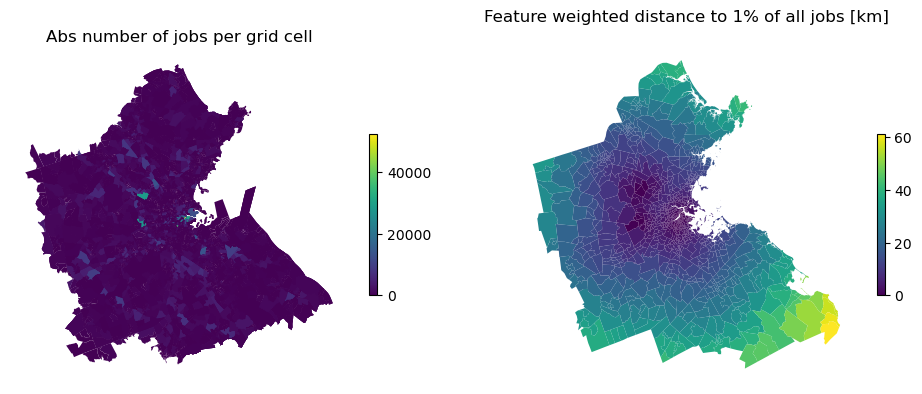

In [88]:
# for visualisation, we cut jobs at bound (ufo map does this internally!)
gdf_employment_cut = gpd.sjoin(gdf_employment, grid)


fig,ax=plt.subplots(ncols=2,figsize=(12,7))
gdf_employment_cut.plot(ax=ax[0], column='num_jobs',legend=True, legend_kwds={'shrink': 0.3})
ax[0].set_axis_off()
ax[0].set_title('Abs number of jobs per grid cell')

gdf_ft_employment.plot(ax=ax[1], column='ft_employment', legend=True, legend_kwds={'shrink': 0.3})
ax[1].set_axis_off()
ax[1].set_title(f'Feature weighted distance to 1% of all jobs [km]')

## 3 Population density
To calculate population density we need number of inhabitants per grid cell and the the grid cells.

In [89]:
# load population data
gdf_pop = utils.read_feature_preproc('pop_dense',path_root,city,crs_local) 
gdf_pop.head()

,total_population,geometry
0,2582,"POLYGON ((2681350.030 5002190.200, 2681206.437..."
1,1276,"POLYGON ((2837195.145 5079022.168, 2837390.521..."
2,392,"POLYGON ((2824227.902 5009629.054, 2824655.580..."
3,382,"POLYGON ((2800186.583 5081568.237, 2800216.623..."
4,672,"POLYGON ((2801275.685 5069601.124, 2801163.298..."


In [91]:
# to calculate population density per grid cell we need to import the feature_in_buffer() function from ufo map (github.com/ai4up/ufo-map)
from ufo_map.Feature_engineering.socio_econ import feature_in_buffer

gdf_ft_pop = feature_in_buffer(grid, # grid cells
                            gdf_pop, # population count
                            'total_population', # varibale name in gdf_pop
                            'ft_pop_dense', # name of the new feature column
                            id_col='tractid', # id of grid cell
                            feature_type='total_per_area') # takes proportional count and divides by grid cell area

gdf_ft_pop.head(5) 

,tractid,geometry,ft_pop_dense
0,630400,"POLYGON ((2798795.938 5028715.690, 2798768.808...",409.782711
1,631100,"POLYGON ((2798768.808 5028674.470, 2798795.938...",870.521226
2,631300,"POLYGON ((2803471.617 5031988.430, 2803466.184...",510.400093
3,631200,"POLYGON ((2801377.149 5033235.500, 2801385.375...",333.781154
4,631400,"POLYGON ((2803393.378 5031922.689, 2803417.638...",2603.088841


Text(0.5, 1.0, 'Feature population density [n/km$^2$]')

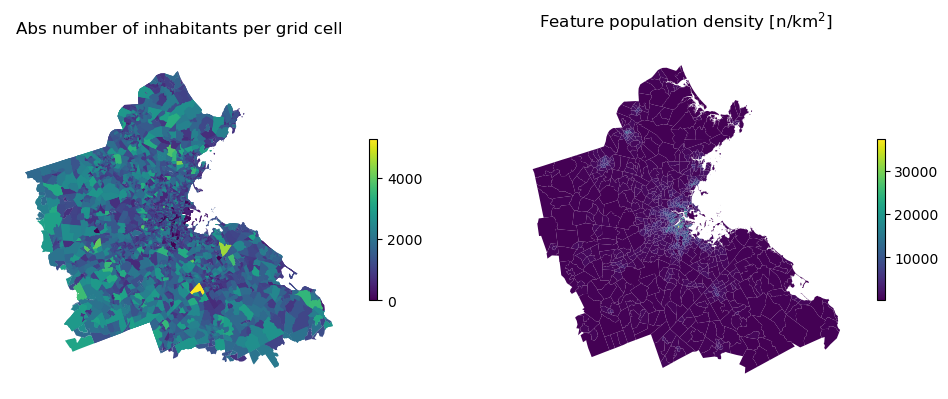

In [108]:
# for visualisation, we cut jobs at bound (ufo map does this internally!)
gdf_pop_cut = gpd.sjoin(gdf_pop, grid)

fig,ax=plt.subplots(ncols=2,figsize=(12,7))
gdf_pop_cut.plot(ax=ax[0], column='total_population',legend=True, legend_kwds={'shrink': 0.3})
ax[0].set_axis_off()
ax[0].set_title('Abs number of inhabitants per grid cell')

gdf_ft_pop.plot(ax=ax[1], column='ft_pop_dense', legend=True, legend_kwds={'shrink': 0.3})
ax[1].set_axis_off()
ax[1].set_title(fr'Feature population density [n/km$^2$]')

## 4 Income
To calculate mean household income per grid cell we need income data per grid cell and the the grid cells.

In [95]:
# load income data
gdf_income = utils.read_feature_preproc('income',path_root,city,crs_local) 
gdf_income[['mean_income','geometry']].head()

,mean_income,geometry
0,77.175263,"POLYGON ((2681350.030 5002190.200, 2681206.437..."
1,101.751781,"POLYGON ((2837195.145 5079022.168, 2837390.521..."
2,42.665975,"POLYGON ((2824227.902 5009629.054, 2824655.580..."
3,28.826754,"POLYGON ((2800186.583 5081568.237, 2800216.623..."
4,71.342183,"POLYGON ((2801275.685 5069601.124, 2801163.298..."


In [96]:
# to calculate population density per grid cell we need to import the feature_in_buffer() function from ufo map (github.com/ai4up/ufo-map)
from ufo_map.Feature_engineering.socio_econ import feature_in_buffer

gdf_ft_income = feature_in_buffer(grid, # grid cells
                                gdf_income, # income data
                                'mean_income', # varibale name in gdf_pop
                                'ft_income', # name of the new feature column
                                'tractid', # id of grid cell
                                feature_type='weighted', # mean value based on area of intersection
                                )
gdf_ft_income.head() 

,tractid,geometry,ft_income
0,630400,"POLYGON ((2798795.938 5028715.690, 2798768.808...",109.186181
1,631100,"POLYGON ((2798768.808 5028674.470, 2798795.938...",79.659521
2,631300,"POLYGON ((2803471.617 5031988.430, 2803466.184...",98.308228
3,631200,"POLYGON ((2801377.149 5033235.500, 2801385.375...",89.917023
4,631400,"POLYGON ((2803393.378 5031922.689, 2803417.638...",53.415521


Text(0.5, 1.0, 'Feature mean income')

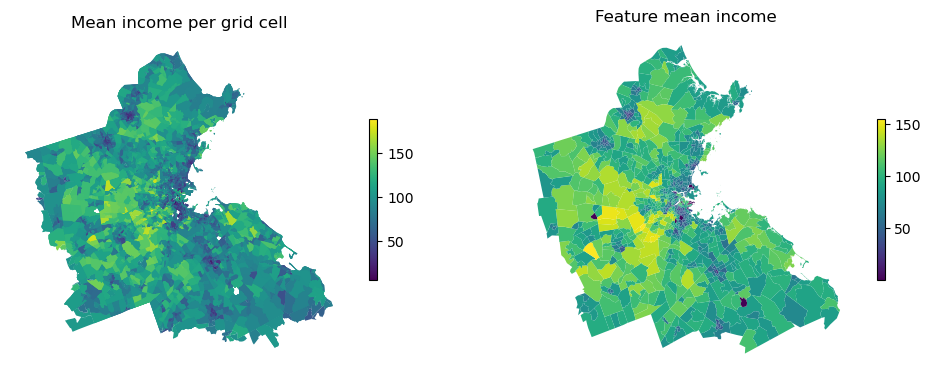

In [99]:
# for visualisation, we cut jobs at bound (ufo map does this internally!)
gdf_income_cut = gpd.sjoin(gdf_income, grid)

fig,ax=plt.subplots(ncols=2,figsize=(12,7))
gdf_income_cut.plot(ax=ax[0], column='mean_income',legend=True, legend_kwds={'shrink': 0.3})
ax[0].set_axis_off()
ax[0].set_title('Mean income per grid cell')

gdf_ft_income.plot(ax=ax[1], column='ft_income', legend=True, legend_kwds={'shrink': 0.3})
ax[1].set_axis_off()
ax[1].set_title(fr'Feature mean income')

## 5 Street connectivity
To calculate street connectiviry per grid cell we need osm streetnetwork data and the the grid cells.

In [103]:
# to calculate street connectivity feature (number of intersection per sqkm, we also refer to it as beta coefficient) 
# we need to import the ft_intersections_per_buffer() function from ufo map (github.com/ai4up/ufo-map)
from ufo_map.Feature_engineering.streets import ft_intersections_per_buffer

ft_street_connectivity = ft_intersections_per_buffer(grid, # grid cells
                                                        g, # osmnx graph
                                                        'ft_beta', # name of the new feature column
                                                        id_col='tractid' # id of grid cell
                                                        )
ft_street_connectivity.head()

,tractid,ft_beta
0,630400,14.533283
1,631100,34.492404
2,631300,15.870086
3,631200,12.396216
4,631400,84.793447


Text(0.5, 1.0, 'Feature street connectivity [n/km$^2$]')

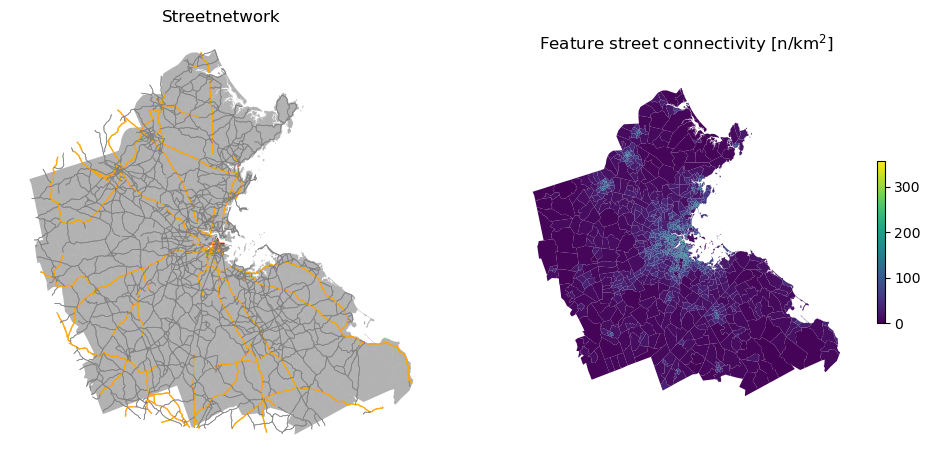

In [107]:
# for visualisation, we cut jobs at bound (ufo map does this internally!)
gdf_street_connectivity = pd.merge(grid, ft_street_connectivity)

fig,ax=plt.subplots(ncols=2,figsize=(12,7))
grid.plot(ax=ax[0], alpha=0.3, color='black')
gdf_edges[gdf_edges.highway=='primary'].plot(ax=ax[0], color='orange',linewidth=0.8) # we only show primary and secondary roads for less computational laod
gdf_edges[gdf_edges.highway=='secondary'].plot(ax=ax[0], color='gray',linewidth=0.5)
gdf_center.plot(ax=ax[0], marker='*', markersize=100, color='red')
ax[0].set_axis_off()
ax[0].set_title('Streetnetwork')

gdf_street_connectivity.plot(ax=ax[1], column='ft_beta', legend=True, legend_kwds={'shrink': 0.3})
ax[1].set_axis_off()
ax[1].set_title(fr'Feature street connectivity [n/km$^2$]')